# Title and Author: Varun Panuganti

# Research Questions:
1. **How do congestion levels correlate with accident frequency under different weather conditions?**
2. **How do congestion levels differ across state and month of the year?**
3. **Are locations with higher traffic congestion, also big contributors of greenhouse gasses?**

# Motivation:
This topic is interesting to me because I feel that traffic congestion is a pivotal part of society, and influences a lot more than we think it does. An increase in traffic congestion can lead to environmental problems, as there are more vehicles on the road. Furthermore, I am significantly interested in the relationship between traffic congestion and accidents. Is it fair to assume that vehicle accidents cause traffic congestion or could it actually be the other way around? What conditions do both happen under? If we can figure out conditions that create car accidents and traffic congestion, such as weather, we can prevent them from occuring.

# Data Setting:
**Dataset 1: https://www.kaggle.com/datasets/sobhanmoosavi/us-traffic-congestions-2016-2022**.
My first database is about traffic congestion accross the United States, and I found it on Kaggle. 
The dataset was collected by a user named Sobhan Moosavi, and it was licensed by CC BY-NC-SA 4.0.
It has 30 columns and 33304199 unique rows, ranging from the severity of the congestion, the geographical location (latitude, longitude, county, state), the weather conditions, and delay from typical traffic and free flow speed, and congestion speed. I think this dataset can provide an insight into congestion trends over time and location.

**Dataset 2: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents**.
My second dataset is about US accidents, and I found it on Kaggle. The dataset was collected by a user named Sobhan Moosavi, and it was licensed by CC BY-NC-SA 4.0. It has 46 columns, ranging from the severity of the accident, the geographical location (latitude, longitude, county, state), the actual setting (railway, crowded street), and the weather conditions. I think this dataset would perfectly complement my congestion dataset, providing an insight into how congestion and accidents are correlated.

**Dataset 3: https://www.kaggle.com/datasets/guslovesmath/us-pollution-data-200-to-2022**.
My third dataset is about US pollution levels, and I found it on Kaggle. The dataset was collected by a user named GUSLOVESMATH, and was licensed by U.S. Government Works. It has 22 columns reporting CO2, O3, and NO2 levels, and showcasing location data. This dataset can provide an insight into how congestion and accidents correlate with pollution levels over time.

# Method:
To begin with, I have 3 research questions described earlier. My first steps will be dataset cleaning and merging a big dataset.

Refer to variables of interest down below.

The first question is **How do congestion levels correlate with accident frequency under different weather conditions?** 

**Visualizations:** For this I can create multiple visualizations. I have weather, congestion severity, and number of accidents, all on a single day in a state. I can create scatterplots of congestion vs accidents for each weather condition.

**Models:** Using the common keys of weather and time, this would provide a valuable insight into which weather events are the most impactful, and how congestion impacts accidents. I can create a linear regression model, where I turn the weather categories into one-hot encoding values. Ultimately, my predictors will be the numerical weather values and the congestion metrics, while the predicted value will be the number of accidents.
 
My next question is **How do congestion levels differ across state and month of the year?**. 

**Visualizations:** For this I can create 2 different visualizations. I can create a bar graph where x is month and y is the congestion severity, and for the second visualization I can create a map where each state is colored in based on congestion severity.

**Models:**
This can provide an insight into how congestion levels vary across each state during each month of the year. Since this is categorical data, I could use a classification model which could predict whether there will be high or low congestion.

The final question is **Are locations with higher traffic congestion, also big contributors of greenhouse gasses?**. 

**Visualizations:** For this I can create a geospatial dataframe showing the traffic congestion across different states, and showing the greenhouse gasses across different states, and see if the trends look similar across location.

**Models:**
This could give an insight into how congestion can have a long lasting environmental impacts on climate change. I can further examine the correlation by comparing 3 different models (DecisionTreeRegressor, GradientBoostingRegressor, and RandomForestRegressor) to see which one is the best at predicting future pollution data.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import doctest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
accidents = pd.read_csv("accidents.csv")
accidents = accidents[["ID", "Start_Time", "State", "Weather_Condition"]].dropna()

/tmp/ipykernel_1154/1717906054.py:1: DtypeWarning: Columns (29,30,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv("accidents.csv")


In [3]:
pollution = pd.read_csv("pollution.csv")
pollution = pollution[["Date", "State", "O3 Mean", "CO Mean", "SO2 Mean", "NO2 Mean"]].dropna()

In [4]:
congestion = pd.read_csv("us_congestion_2016_2022_sample_2m.csv")
congestion = congestion[["Severity", "StartTime", "DelayFromTypicalTraffic(mins)", "DelayFromFreeFlowSpeed(mins)", "Congestion_Speed", "State"]].dropna()

Rationale for this filtering will be explained in variables of interest.

In [5]:
weather_buckets = {
    'Clear': ['Clear', 'Fair', 'Fair / Windy'],
    'Cloudy': ['Cloudy','Overcast','Mostly Cloudy','Partly Cloudy','Scattered Clouds',
        'Cloudy / Windy','Mostly Cloudy / Windy','Partly Cloudy / Windy', 'Cloud Cover'],
    'Heavy Rain': ['Heavy Rain','Rain Showers','Rain Shower','Heavy Rain Showers','Light Rain Shower',
        'Showers in the Vicinity','Rain / Windy','Heavy Rain / Windy','Freezing Rain','Heavy Freezing Rain',
        'Heavy Freezing Rain / Windy'],
    'Light Rain':['Rain','Light Rain','Light Freezing Rain','Freezing Drizzle','Light Freezing Drizzle',
        'Light Freezing Rain / Windy','Light Rain Showers','Light Drizzle','Light Rain / Windy',
        'Light Rain Shower / Windy','Light Drizzle / Windy','Drizzle and Fog','Drizzle','Heavy Drizzle'],
    'Storm(Thunder/Hail/Tornado)': [
        'Thunderstorm','T-Storm','Heavy T-Storm',
        'Light Thunderstorms and Rain','Thunderstorms and Rain','Heavy Thunderstorms and Rain',
        'Thunder','Thunder in the Vicinity','Light Rain with Thunder',
        'Heavy T-Storm / Windy','T-Storm / Windy','Thunder / Windy',
        'Squalls','Squalls / Windy',
        'Hail','Small Hail','Funnel Cloud','Tornado',
        'Light Thunderstorms and Snow','Heavy Thunderstorms and Snow',
        'Snow and Thunder','Snow and Thunder / Windy','Thunder / Wintry Mix',
        'Light Snow with Thunder'],
    'Snow': [
        'Snow','Heavy Snow','Light Snow','Snow Showers','Light Snow Shower',
        'Snow Grains','Blowing Snow','Low Drifting Snow',
        'Snow / Windy','Light Snow / Windy','Heavy Snow / Windy',
        'Blowing Snow / Windy'],
    'Sleet/Ice': [
        'Sleet','Light Sleet','Sleet / Windy','Light Sleet / Windy',
        'Snow and Sleet','Light Snow and Sleet','Snow and Sleet / Windy',
        'Light Snow and Sleet / Windy',
        'Ice Pellets','Light Ice Pellets','Heavy Ice Pellets',
        'Wintry Mix','Wintry Mix / Windy'],
    'Fog/Smoke': [
        'Fog','Shallow Fog','Light Fog','Patches of Fog','Fog / Windy',
        'Mist','Mist / Windy',
        'Haze','Light Haze','Haze / Windy',
        'Smoke','Smoke / Windy',
        'Light Freezing Fog'],
    'Dust/Ash': [
        'Blowing Dust','Blowing Dust / Windy','Widespread Dust','Widespread Dust / Windy',
        'Sand','Blowing Sand','Sand / Dust Whirlwinds',
        'Volcanic Ash'],
    'Other': ['N/A Precipitation']
}
def weather_bucket(weather):
    """
    This function is used to map the weather type to the weather bucket. Its purpose is to reduce the amount of categories. It 
    takes in the weather category as a parameter and returns the category it will be changed to.

    >>> weather_bucket('Clear')
    'Clear'
    >>> weather_bucket('Mostly Cloudy / Windy')
    'Cloudy'
    >>> weather_bucket('Showers in the Vicinity')
    'Heavy Rain'
    >>> weather_bucket('Light Drizzle / Windy')
    'Light Rain'
    >>> weather_bucket('Heavy Thunderstorms and Rain')
    'Storm(Thunder/Hail/Tornado)'
    >>> weather_bucket('Light Snow / Windy')
    'Snow'
    >>> weather_bucket('Light Snow and Sleet')
    'Sleet/Ice'
    >>> weather_bucket('Haze / Windy')
    'Fog/Smoke'
    >>> weather_bucket('Widespread Dust / Windy')
    'Dust/Ash'
    >>> weather_bucket('N/A Precipitation')
    'Other'
    """
    
    buckets = ['Clear', 'Cloudy', 'Heavy Rain', 'Light Rain', 
               'Storm(Thunder/Hail/Tornado)', 'Snow', 'Sleet/Ice',
               'Fog/Smoke', 'Dust/Ash', 'Other']
    for bucket in buckets:
        weather_list = weather_buckets[bucket]
        if weather in weather_list:
            return bucket

accidents["Weather_Condition"] = accidents["Weather_Condition"].apply(weather_bucket)
doctest.run_docstring_examples(weather_bucket, globals())

After figuring out what different categories exist, we can organize them into buckets.

# Variables of interest and How the datasets are related to each other:
The dataset I want to be working with must contain these requirements:
1. Each row must be an instance of a specific date in a specific state
2. It must have data on traffic congestion severity (whatever the metric(s) may be)
3. It must have data on number of accidents
4. It must have data on pollution severity (whatever the metric(s) may be)

I do not have a dataset that has all requirments, but I have a dataset that can meet requirements 1 and 2, a dataset that can meet requirements 1 and 3, and a dataset that can meet requirements 1 and 4. Ultimately once all transformations are done on each dataset individually, each dataset will be related by requirement 1, meaning each row is an instance of a specific date in a specific date. this leaves me with the necessary process below:

I know I will be working with date (I am picking date instead of time for the sake of data storage) and state (I am picking state as my location metric rather than time for the sake of data storage). I will be grouping by date and location so that I only have one instance of a specific date on a specific location. This means I will need to do group up and aggregate the other columns I am working with. 

I want accident data, so I will pick number of accidents (I will use count as my aggregate function). I do have access to accident severity and could do that instead, but there could be 50 accidents on a day with average severity 20, and 2 accidents another day with average severity 21, so that is misinformative. 

For congestion, I am currently planning on using **Severity**, **DelayFromTypicalTraffic(mins)**, **DelayFromFreeFlowSpeed(mins)**, and **Congestion_Speed**, as these are valuable congestion metrics. For this assignment, for testing purposes I will focus on using **Severity** which is the severity of the traffic congestion on a scale of 1 to 4.

I will use **O3 Mean**, **CO Mean**, **SO2 Mean**, and **NO2 Mean**, as my pollution metrics. For this assignment, for testing purposes I will focus on using **CO Mean** which is the mean of CO2 emissions for a date and state.

To merge on date and state, I must do any manipulations of these columns necessary so that they match. After that, I must do groupby(date, state), for each dataset so each data set has only date state instance (12/12/12 in WA should only appear once).

For now, my variables of interest are **Date**, **State**, **Weather_Condition**, **CO Mean**, **Severity**

## Merging:

For this project I am planning on using geospatial data. I need data that contains geometries for U.S. states so I chose this dataset from online, which I plan to extract the state geometries from: https://www.census.gov/geographies/mapping-files/2018/geo/carto-boundary-file.html.

Furthermore, I need to do different aggregate functions for different columns when im grouping, so I used this documentation:
https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.agg.html#

In [6]:
def cut(time):
    """
    This method will turn strings which contain both date and time format into just strings that contain date. Its parameter is
    a date time String and it will return a date String.

    >>> cut('2016-02-08 06:49:27')
    '2016-02-08'

    >>> cut('2022-12-15 12:34:59')
    '2022-12-15'
    """
    date = time[:10]
    return date

def mode_func(aux):
    """
    This method will return the mode of a vector. The parameter is a vector, the value returned is the mode. If there are multiple 
    modes, the first one will be returned.

    >>> mode_func(pd.Series([1,2,2,3,4]))
    2

    >>> mode_func(pd.Series([1,2,3,3,4,4]))
    3
    """
    modes = aux.mode()
    
    return modes.iloc[0]

accidents["Date"] = accidents["Start_Time"].apply(cut)
accidents = accidents.groupby(["Date", "State"]).agg({"Weather_Condition":mode_func, 
                                                          "ID":'count'})
accidents = accidents.reset_index()

congestion["Date"] = congestion["StartTime"].apply(cut)
congestion = congestion.groupby(["Date", "State"]).agg({"Severity":"mean", 
                                                            "DelayFromTypicalTraffic(mins)":"mean",
                                                            "DelayFromFreeFlowSpeed(mins)":"mean"})
congestion = congestion.reset_index()

pollution = pollution.groupby(["Date", "State"]).agg({"O3 Mean":"mean", "CO Mean":"mean",
                                                      "SO2 Mean":"mean", "NO2 Mean":"mean"})
pollution = pollution.reset_index()

full_to_abbreviated = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District Of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

def change_abbreviation(word):
    """
    This method will return the abbreviated version of a state. The paramter is a full state name, the output is the abbreviated 
    format.
    
    >>> change_abbreviation('Alabama')
    'AL'

    """
    return full_to_abbreviated[word]

pollution["State"] = pollution["State"].apply(change_abbreviation)

merged_data = accidents.merge(congestion, on = ["Date","State"])
merged_data = merged_data.merge(pollution, on = ["Date","State"])
merged_data["Date"] = pd.to_datetime(merged_data["Date"])

state_geometries = gpd.read_file("cb_2018_us_state_5m.shp")
state_geometries = state_geometries[["STUSPS", "geometry"]]
merged_data = merged_data.merge(state_geometries, how = 'left', left_on = 'State', right_on = 'STUSPS')
merged_data = merged_data.rename(columns={"ID": "accidents"})

doctest.run_docstring_examples(cut, globals())
doctest.run_docstring_examples(mode_func, globals())
doctest.run_docstring_examples(change_abbreviation, globals())
print(merged_data)

            Date State Weather_Condition  accidents  Severity  \
0     2016-02-08    OH            Cloudy         36  1.357143   
1     2016-02-09    OH              Snow         35  1.357143   
2     2016-02-10    OH              Snow         16  1.478261   
3     2016-02-11    OH            Cloudy         35  1.583333   
4     2016-02-12    OH              Snow          7  1.461538   
...          ...   ...               ...        ...       ...   
17852 2022-09-08    OR             Clear          4  2.000000   
17853 2022-09-08    PA            Cloudy         38  1.100000   
17854 2022-09-08    TX             Clear         75  1.257143   
17855 2022-09-08    VA            Cloudy         20  1.125000   
17856 2022-09-08    WA             Clear         10  1.416667   

       DelayFromTypicalTraffic(mins)  DelayFromFreeFlowSpeed(mins)   O3 Mean  \
0                           3.393571                      3.612143  0.017625   
1                           4.315357                      4

# How large are my datasets?

In [7]:
merged_data_rows, merged_data_columns = merged_data.shape
print(f"The delays dataset has {merged_data_rows} rows and {merged_data_columns} columns")

The delays dataset has 17857 rows and 13 columns


# How many missing values are there?

In [8]:
columns = merged_data.columns
for column in columns:
    missing = merged_data[column].isna()
    print(len(merged_data[column][missing]))

0
0
0
0
0
0
0
0
0
0
0
0
0


As it can be seen in the output, no column has missing data.

# **EDA Results:**
**What steps did you take during your EDA that prepared the work you conducted for the rest of your analysis?**
I believe my EDA set me up perfectly well for the rest of my analysis. By the time my EDA was completed, I had successfully merged all my datasets and created half of the visualizations necessary for my final product. I also had all the necessary visualization templates necessary (if I needed to create a map, barplot, scatterplot, I had an existing one in this file). 

**What did you learn about your data from doing the EDA?**
I learned about the correlations between my manipulating and responding variables for each question. This not only gave me insight into what visualizations would best represent my data, but also what models I could efficiently train.

**How did your understanding of the data setting change?**
My understanding of the data setting changed from the EDA as I realized I had far too much data to work with. I realized I had to reduce my rows so that they would go from specific location points to just State, and my weather categories to just weather buckets.

# **Results of Question 1:**
## Visualizations for Q1:
For the first one we will be observing the correlation between congestion and accidents under different weather conditions. The best possible visualization for this would be a line for each weather condition plotted across a single graph.

## Method Creation:
For starters, we want to create 2 different methods, one that shows x vs accidents for each weather, and one that shows x vs accidents overall (x in this scenario will be congestion, delay from typical traffic, and delay from typical speed).

In [9]:
def plot_of_x_weather_vs_accidents(x):
    weather_conditions = merged_data["Weather_Condition"].unique()
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (12,12))
    axes = axes.flatten()
    for i in range(0,9):
        weather_condition = weather_conditions[i]
        ax = axes[i]
        sns.scatterplot(merged_data[merged_data["Weather_Condition"] == weather_condition],
                        x=x, y="accidents", ax=ax)
        ax.set_title(f"{x} vs Number of Accidents for {weather_condition}")
        ax.set_xlabel(x)
        ax.set_ylabel("Number of Accidents")
    plt.subplots_adjust(bottom=1, right=2, top=2)
    fig.show()

def plot_of_x_vs_accidents(x):
    plot = sns.scatterplot(merged_data, x=x, y="accidents")
    plot.set(title=f"{x} vs Number of Accidents", xlabel=x, ylabel="Number of Accidents")


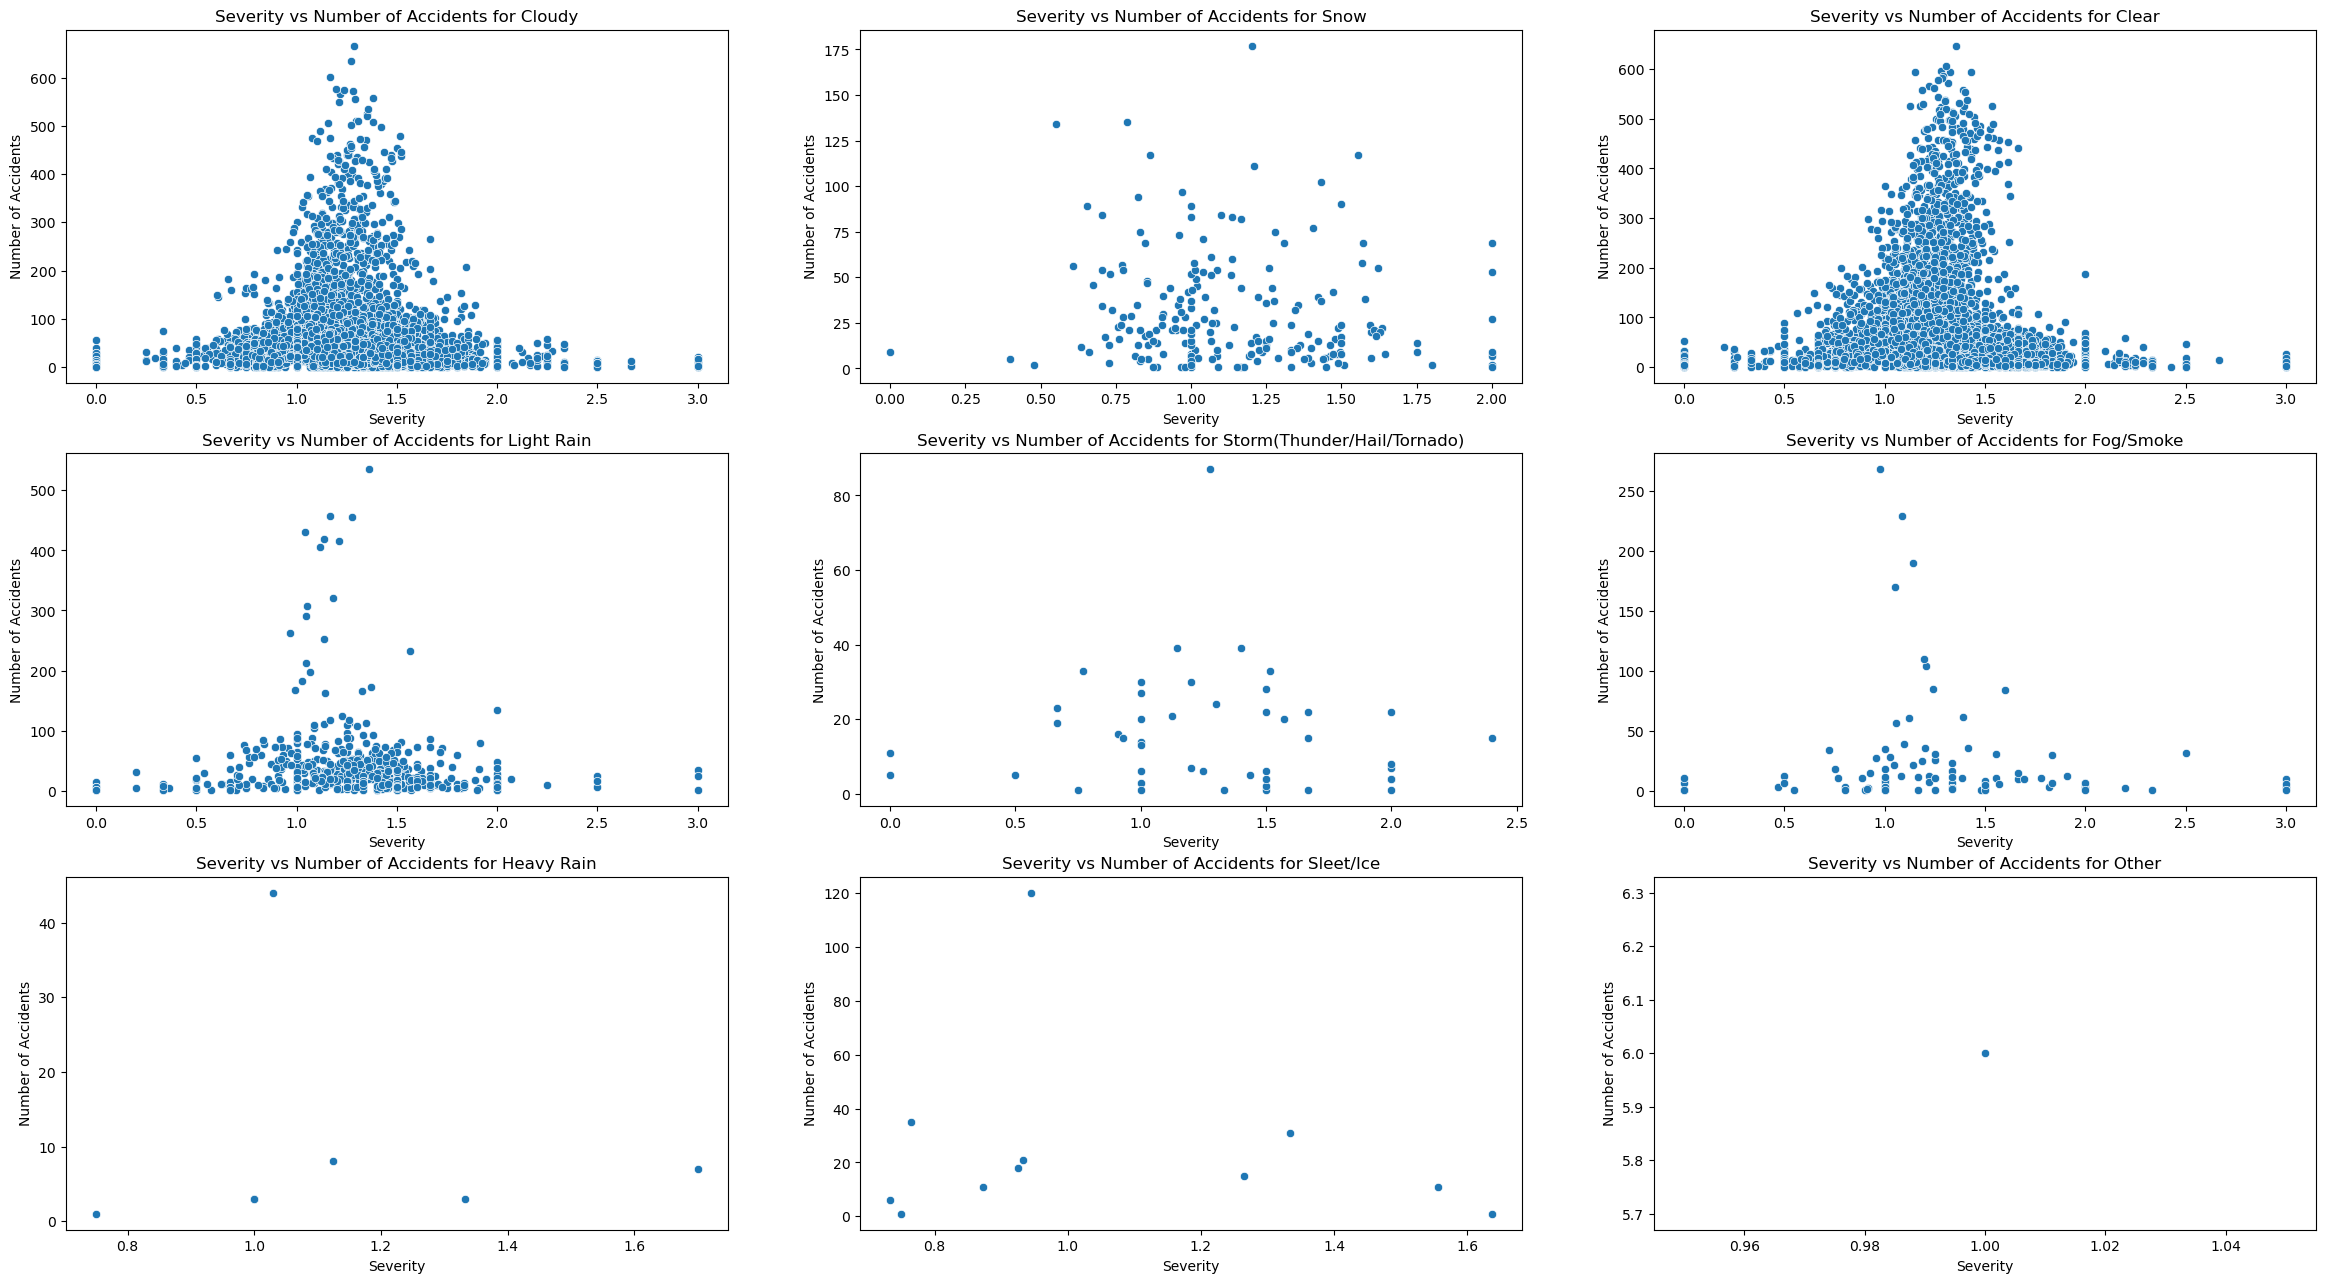

In [10]:
plot_of_x_weather_vs_accidents("Severity")


We can see after concluding these visualizations that the trend in traffic congestion severity vs number of accidents appears to be the same accross all weather patterns, it is a bell curve. The only difference appears to be that there are more accidents for certain weather types. To test out this hypothesis, I must plot 2 visualizations that show overall trends, and quantitative differences between weather patterns.

For starters, the best visualization for overall trend would just be the same scatterplot format, except not filtering for weather type and plotting subplots.

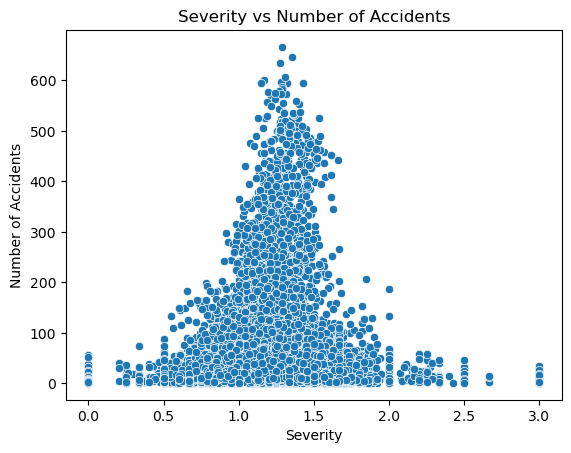

In [11]:
plot_of_x_vs_accidents("Severity")

We can see that my hypothesis was correct, as the plot is a bell curve. I interpret that this means that a medium level of congestion is where the highest risk of accident lies. A potential explanation for this could be that when there are fewer cars on the road, the chance of cars hitting each other is small, and when traffic is very high, there are so many cars that they cannot even travel faster than a certain speed due to traffic. However in the middle cars can travel at a high speed and there is still a medium amount of cars on the street that could get hit.

The next step is to observe accidents with respect to delay from typical traffic(mins), and delay from free flow speed(mins). This can be done by just changing the x value from traffic severity to DelayFromTypicalTraffic(mins) and DelayFromFreeFlowSpeed(mins).

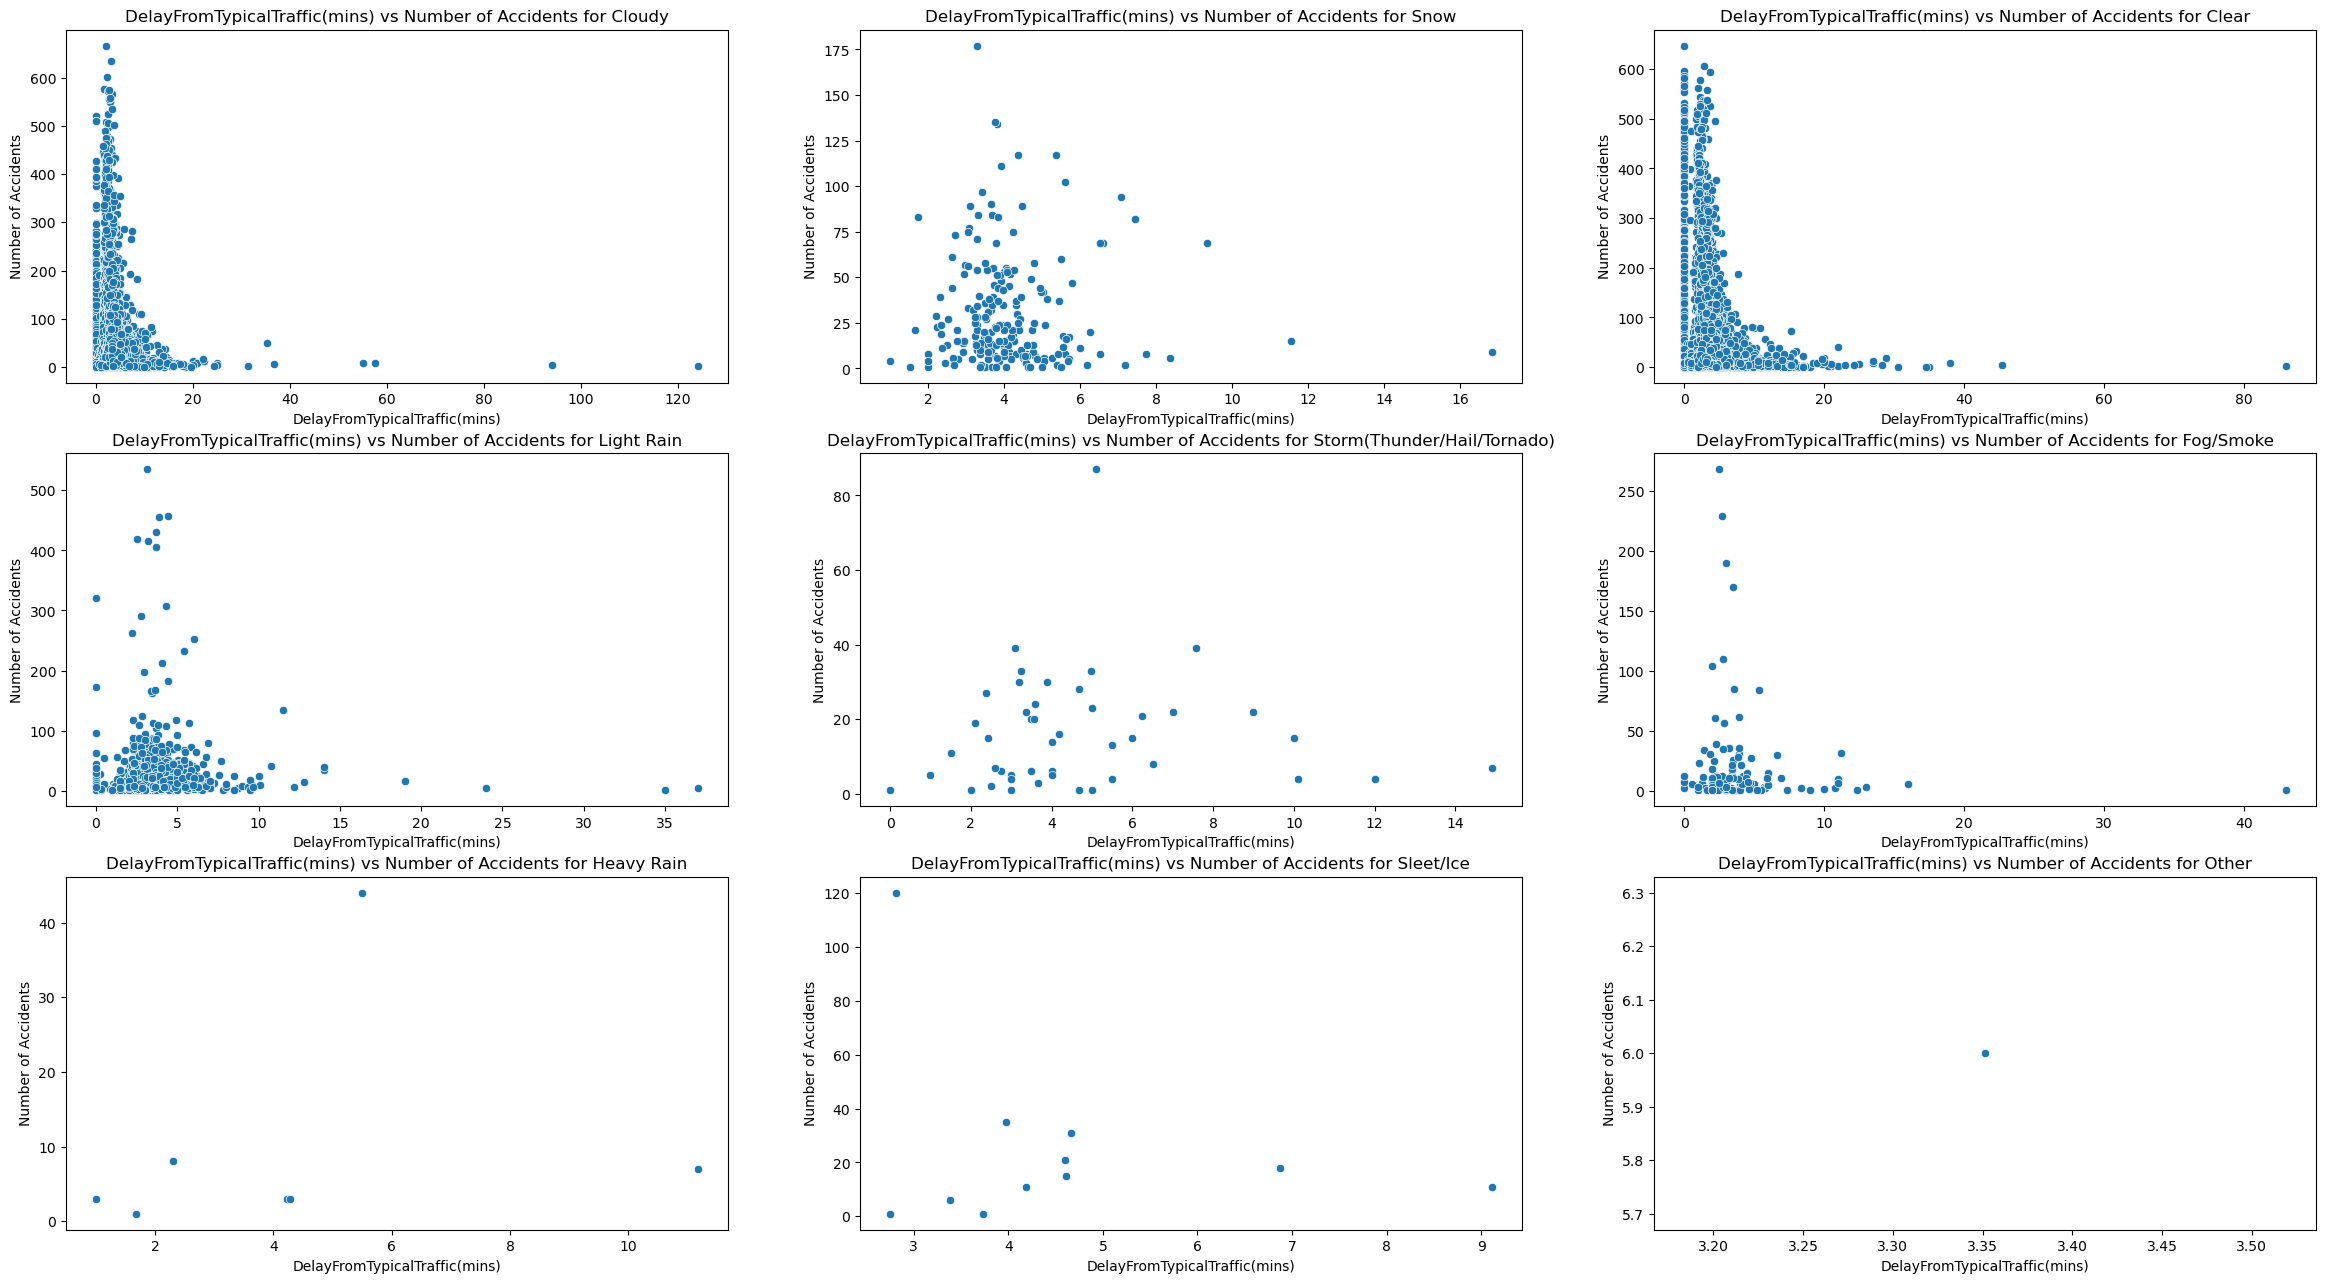

In [12]:
plot_of_x_weather_vs_accidents("DelayFromTypicalTraffic(mins)")

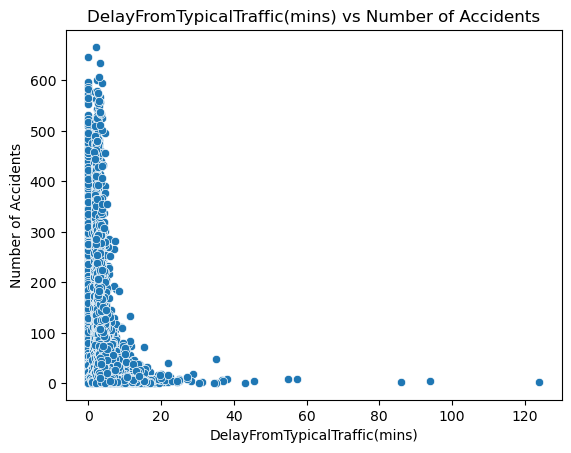

In [13]:
plot_of_x_vs_accidents("DelayFromTypicalTraffic(mins)")

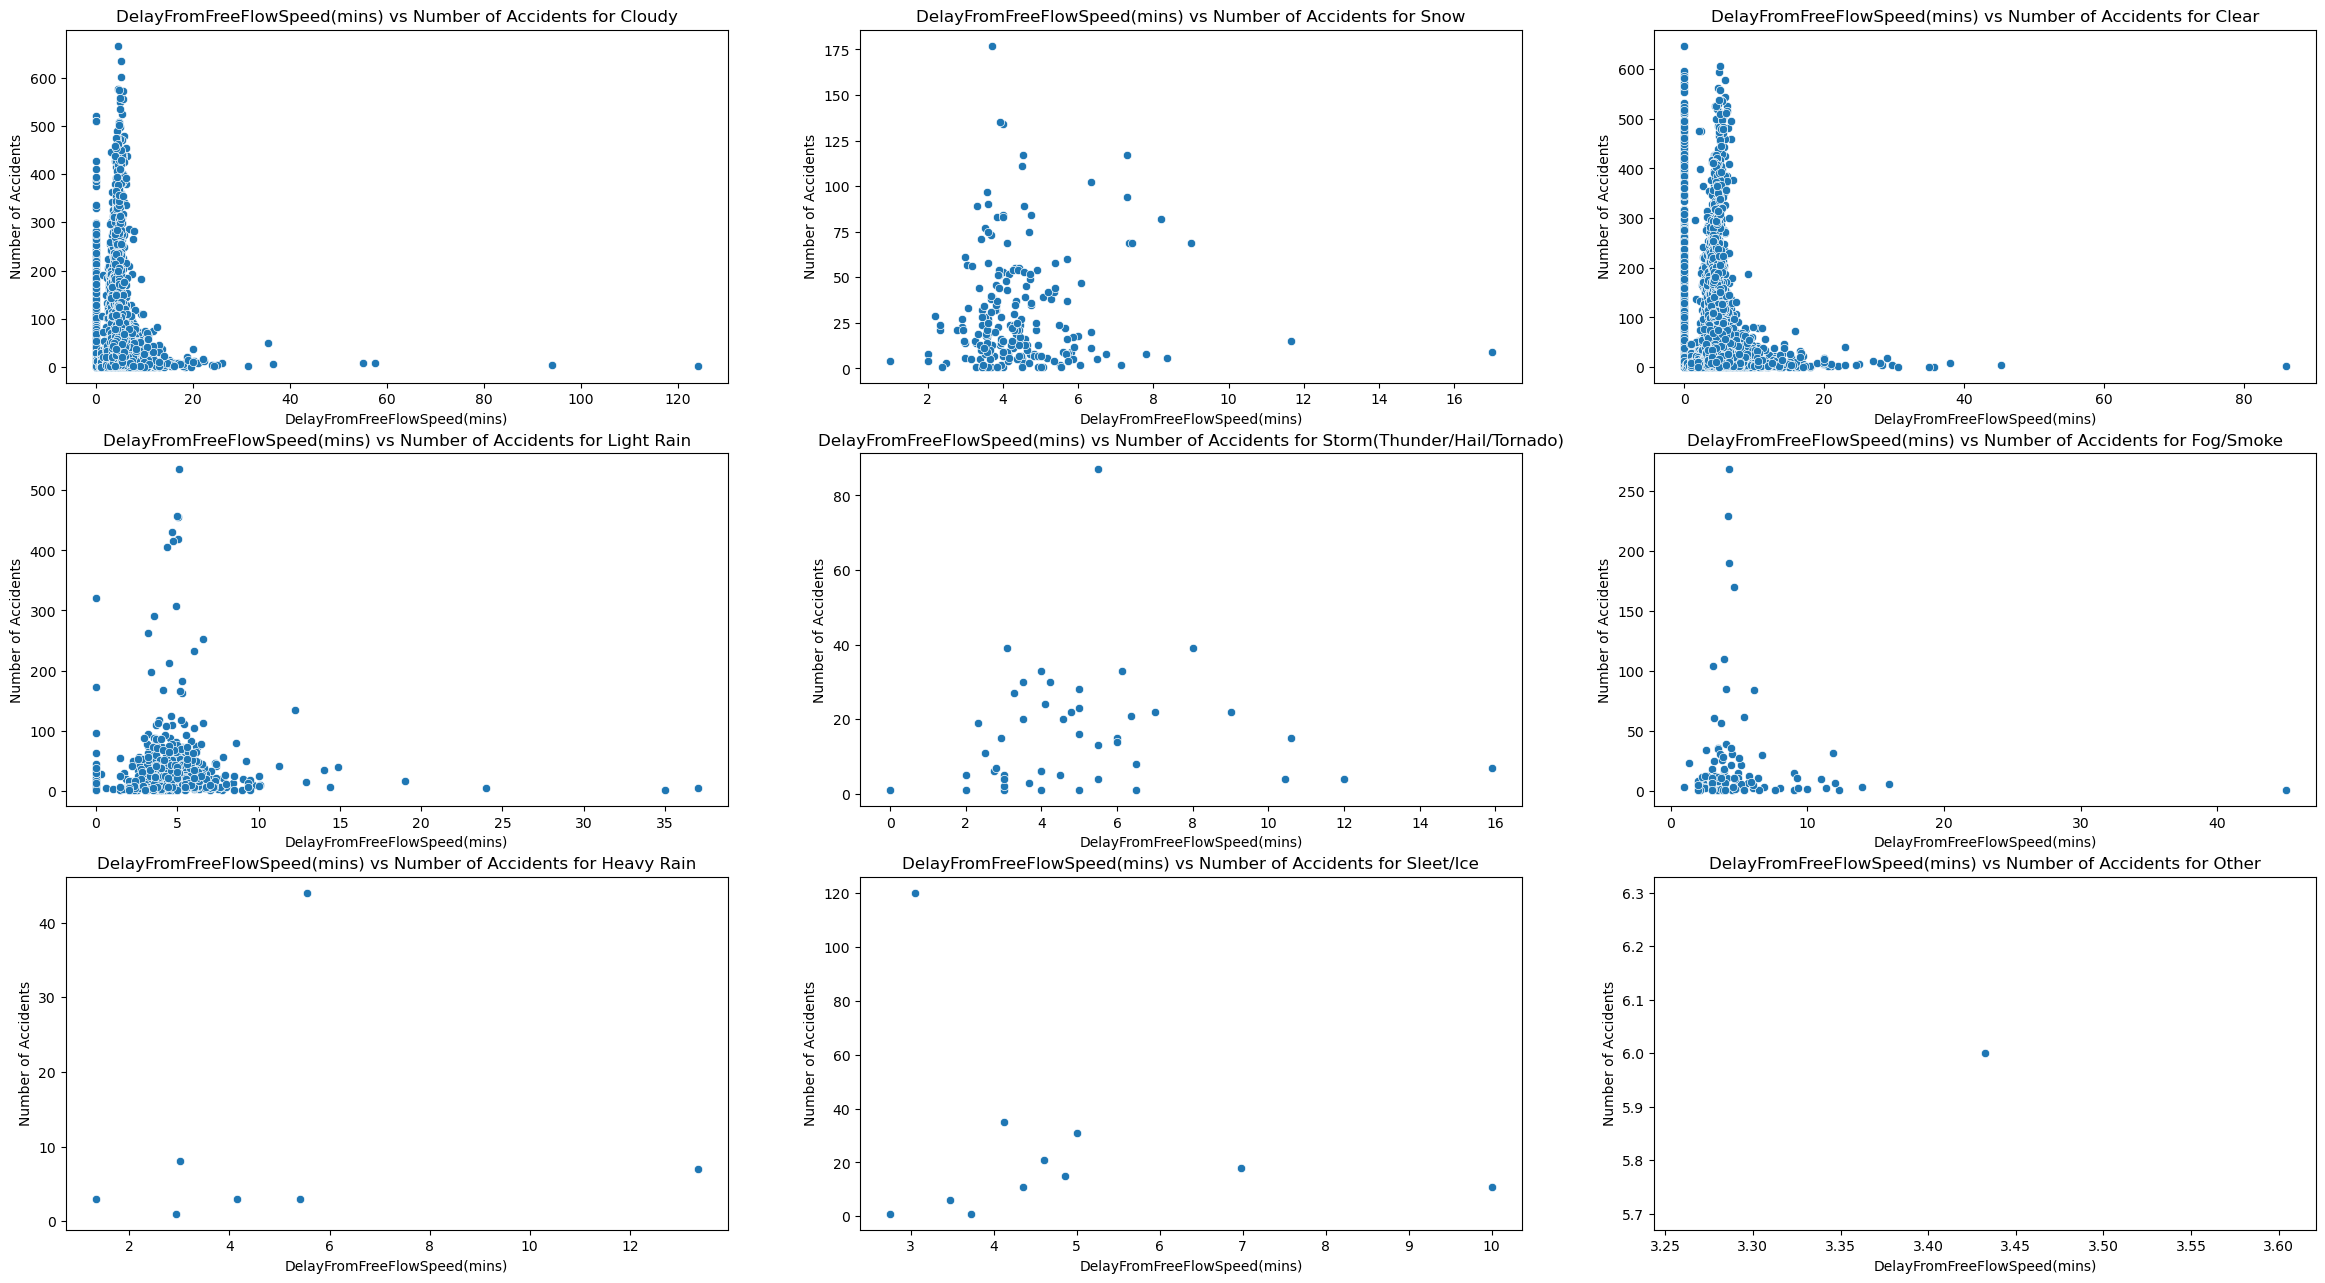

In [14]:
plot_of_x_weather_vs_accidents("DelayFromFreeFlowSpeed(mins)")

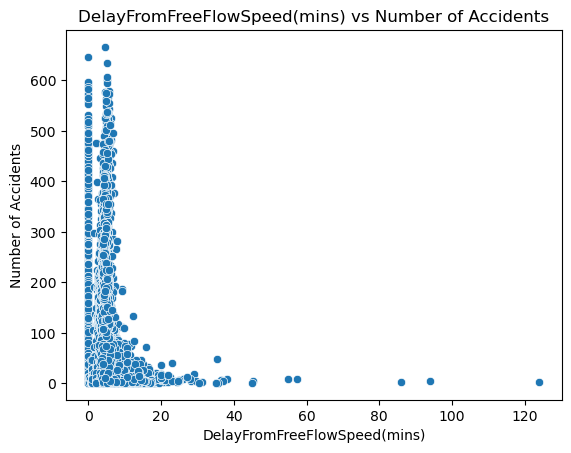

In [15]:
plot_of_x_vs_accidents("DelayFromFreeFlowSpeed(mins)")

Based on these visualizations, we can see that both delay from typical traffic and free flow speed follow a different trend than traffic congestion. Rather than hugging the middle like a bell curve, they the y axis and are right skewed. This shows that accidents occur the most when there is a small from free flow speed and typical traffic. I think this is because of 2 things. For starters, this is real world data so there is probably noise that skews these results. I also think this reveals that traffic congestion may not be directly correlated with both these delay metrics.

The final visualization for this question, shows the relationship between just weather condition and number of accidents, which we can do using a bar-graph.

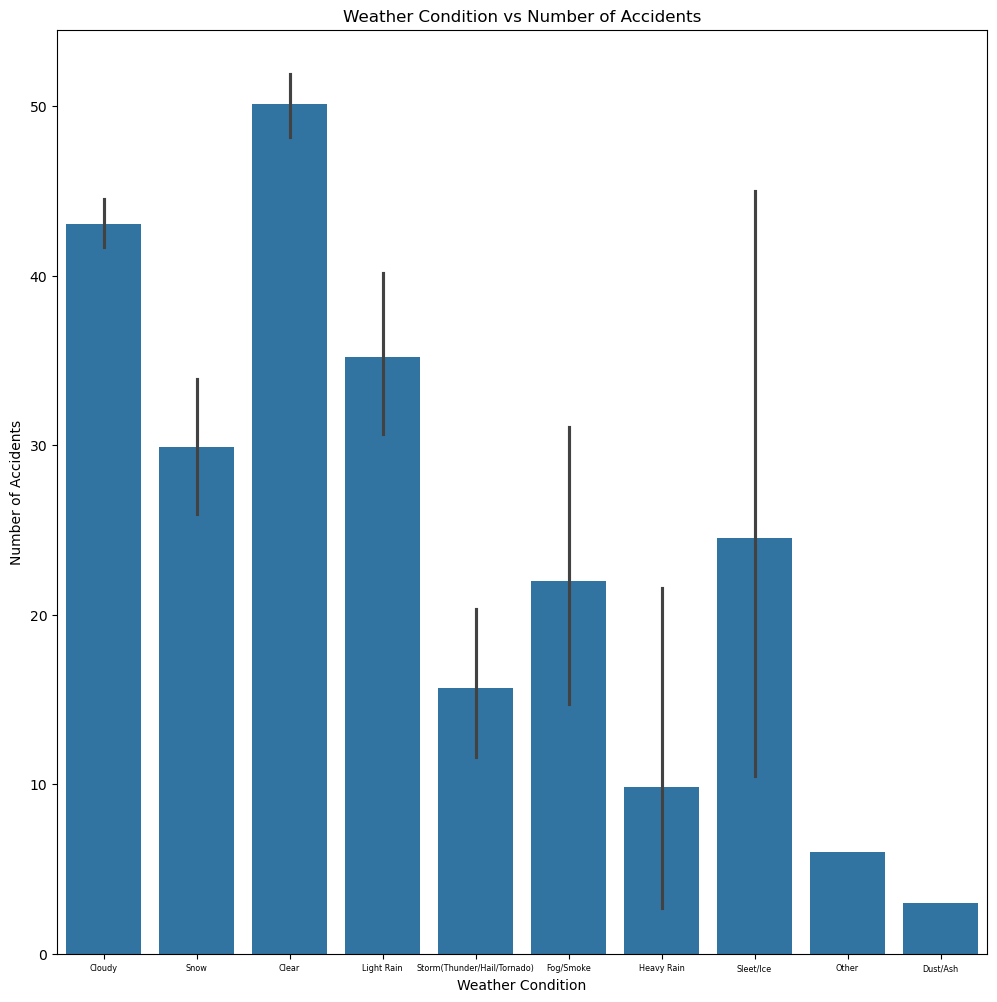

In [16]:
fig, ax = plt.subplots(figsize = (12, 12))
sns.barplot(merged_data, x="Weather_Condition", y="accidents", ax = ax)
ax.set_title("Weather Condition vs Number of Accidents")
ax.set_xlabel("Weather Condition")
ax.set_ylabel("Number of Accidents")
ax.tick_params(axis="x", labelsize=5.8) 
fig.show()

The results are very interesting, as the most accidents actually occur undernath under the "Clear" bucket. While I am not entirely sure as to why this is occuring my best guess could be that people do not even leave their homes under poor weather. So even though poor weather conditions could make the road more dangerous, there are so many more people that go out during "Clear" weather that the number of accidents is significantly higher.

## Regression Model for Q1:
For the first question, we are going to train a regression model that predicts the number of accidents using the congestion data such as the severity, delay from typical traffic(mins), and delay from free flow speed(mins). Since we want to use the weather categories as predictors, and this is a regression model, we want to use one hot encoding to change them into 0s and 1s.

In [17]:
q1_df = pd.get_dummies(merged_data, columns = ["Weather_Condition"], drop_first = True)

q1_weather_features = [column for column in q1_df if column.startswith("Weather_Condition_")]

q1_prediction_features = q1_weather_features + ["Severity", 
                                          "DelayFromTypicalTraffic(mins)", 
                                          "DelayFromFreeFlowSpeed(mins)"]

q1_X = q1_df[q1_prediction_features]
q1_y = q1_df["accidents"]

q1_X_train, q1_X_test, q1_y_train, q1_y_test = train_test_split(q1_X, q1_y, test_size=0.2)
reg = LinearRegression().fit(q1_X_train, q1_y_train)

print("Train Error:", root_mean_squared_error(q1_y_train, reg.predict(q1_X_train)))
print("Trest Error:", root_mean_squared_error(q1_y_test, reg.predict(q1_X_test)))

Train Error: 71.95652302408567
Trest Error: 72.88757048301078


When searching up "how do i know if a regression models rmse is good" on google, I learned that a regression model's RMSE is good if it is less than the standard deviation of the data. Here we will check that.

In [37]:
merged_data['accidents'].describe()

count    17857.000000
mean        45.567677
std         75.302285
min          1.000000
25%          7.000000
50%         20.000000
75%         47.000000
max        666.000000
Name: accidents, dtype: float64

# Summary for Q1:
Ultimately, I think that a linear regression model is somewhat decent at predicting accidents, using congestion data and weather conditions as predictors. The test RMSE is almost always below 75 when running. I believe that alongside the linear regression predictor, we can still come to conclusions on why accidents occur and under what circumstances. To summarize my findings, accidents occur the most under clear conditions, when traffic congestion is at a medium, and the delay from typical traffic and free flow speed is very small. 

# **Results of Question 2:**
## Visualizations for Q2:
For the next question we'll look at the relationship between month and congestion level(using a bar graph), and the trends of congestion severity over each state, potentially identifying any correlation. 

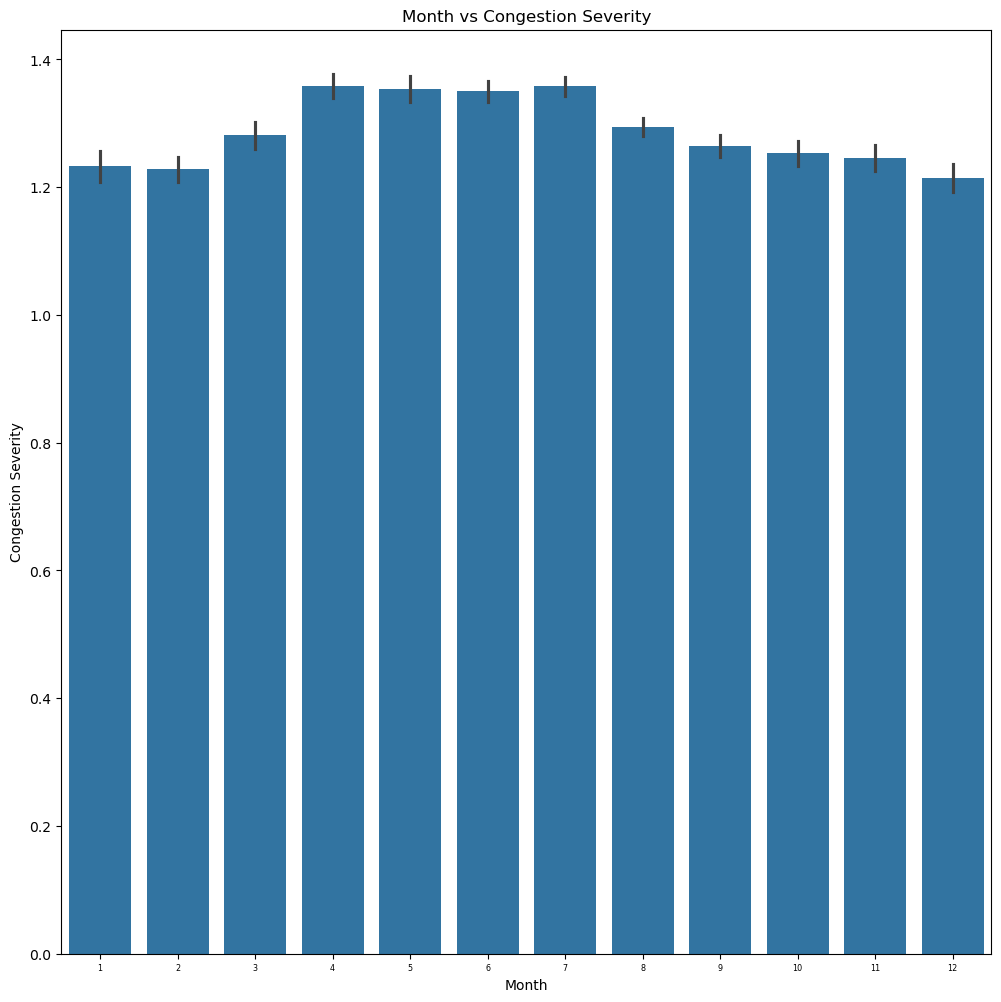

In [18]:
merged_data["Month"] = merged_data["Date"].dt.month
fig, ax = plt.subplots(figsize = (12, 12))
sns.barplot(merged_data, x="Month", y="Severity", ax = ax)
ax.set_title("Month vs Congestion Severity")
ax.set_xlabel("Month")
ax.set_ylabel("Congestion Severity")
ax.tick_params(axis="x", labelsize=5.8) 
fig.show()

When looking at the bar graph results we can see that the congestion severity is actually very similar across the entire year. However, one can notice that it peaks around the end of spring to the beginning of summer. I believe this makes sense, as that is normally the peak period of tourism and travel. More people are outside due to the sunny and clear weather.

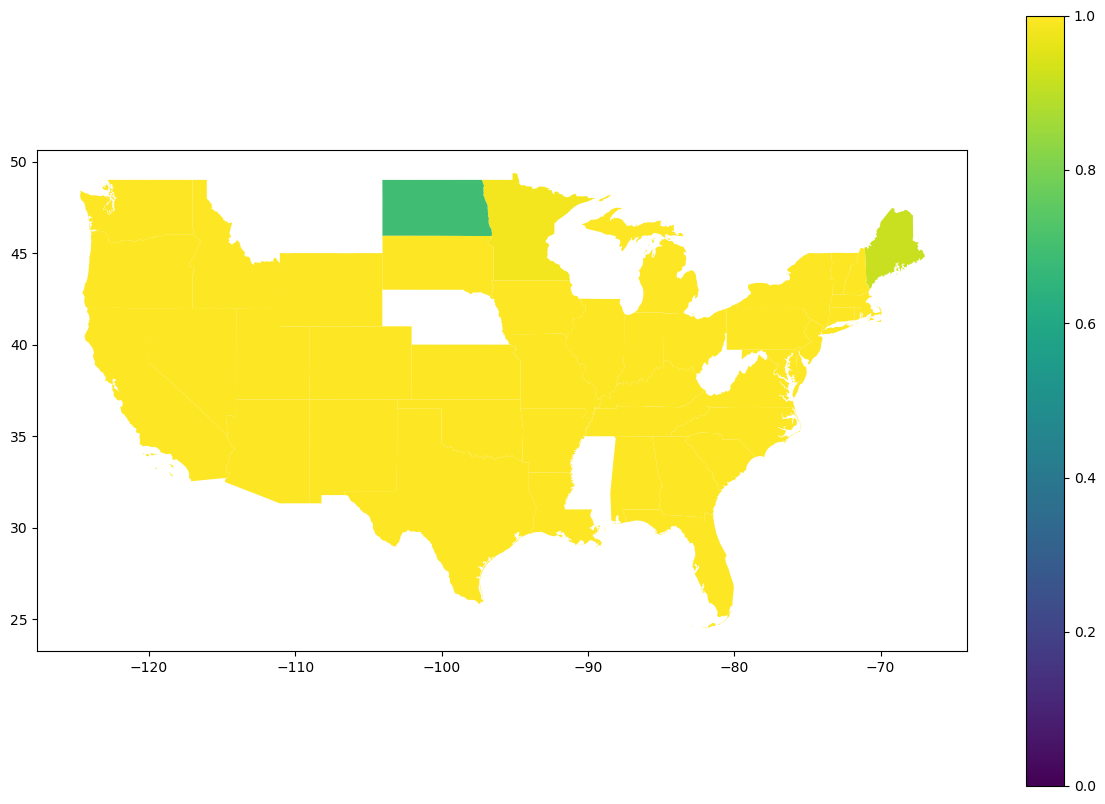

In [21]:
q2_merged_data_subset = gpd.GeoDataFrame(data = merged_data[["State", "Severity", "geometry"]], 
                                      geometry = "geometry")
q2_merged_data_dissolved = q2_merged_data_subset.dissolve(by = "State", aggfunc = "mean")
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
q2_merged_data_dissolved.plot(ax=ax1, column="Severity", legend=True, vmin = 0, vmax = 1)
ax2.set(title = "Congestion Severity over state")
fig.show()


When looking at the geoplot results we can actually see that the congestion severity does not vary much across states. I think there are several reasons as to why this is the case for this visualization. For starters, each state is the data averaged across each county. This means that internal information may be lost. I also think that because this is real data and not synthetic, there must be a significant amount of noise swaying the result. The only states that seem to have lower congestion are North Dakota and Maine. I did a quick google search of "states with the lowest population", and sure enough, whether it was top 10 or top 5 least populated states, North Dakota and Maine popped up in my results.

## Classification Model for Q2:
For the second question, we are going to train a classification model to predict the congestion level across the state and month of the year. Our predictors will be month and state. State is categorical so we will once again need to change it to numerical values using one hot encoding. We want to predict congestion levels in buckets (since we're using classification), where one bucket is high congestion (greater than the mean), and low congestion (lesser than the mean).

In [29]:
merged_data["Congestion_Bucket"] = (merged_data["Severity"].mean() <= merged_data["Severity"])

q2_df = pd.get_dummies(merged_data, columns = ["State"], drop_first = True)

q2_state_features = [column for column in q2_df if column.startswith("State_")]

q2_prediction_features = q2_state_features + ["Month"]

q2_X = q2_df[q2_prediction_features]
q2_y = q2_df["Congestion_Bucket"]

q2_X_train, q2_X_test, q2_y_train, q2_y_test = train_test_split(q2_X, q2_y, test_size=0.2)
reg = LogisticRegression(max_iter=1000).fit(q2_X_train, q2_y_train)

print("Train Accuracy Score:", 
      accuracy_score(q2_y_train, reg.predict(q2_X_train), normalize=True, sample_weight=None))
print("Test Accuracy Score:", 
      accuracy_score(q2_y_test, reg.predict(q2_X_test), normalize=True, sample_weight=None))
n = len(q2_y)
true_count = q2_y.sum()
false_count = len(q2_y)-true_count
print(f"True Percentage: {true_count/n}")
print(f"False Percentage: {false_count/n}")

Train Accuracy Score: 0.623661183059153
Test Accuracy Score: 0.6189809630459127
True Percentage: 0.48401187209497676
False Percentage: 0.5159881279050232


# Summary for Q2:
Ultimately, I think that the logistic regression model is somewhat decent at predicting congestion labels using state and month as predictors. When looking at the percentage of true's and false's one can see that a blind guess would have a 50% chance of being correct. This logistic model is almost 10% better than a blind guess which shows it is actually learning something. Alongside a logistic model, we can also utilize my findings from my visualizations to understand this relationship. To summarize my findings, traffic congestion peaks during the middle of the year (near the end of Spring and throughout Summer) due to more people being out during better weather, and is relatively high across every single state across the United States except very rural states like North Dakota and Maine.

# **Results of Question 3:**
## Visualizations for Q3:
For the final question we'll compare the 2 relationships of pollution vs state and congestion vs state to determine whether states that have high congestion are also heavily affected by pollution.

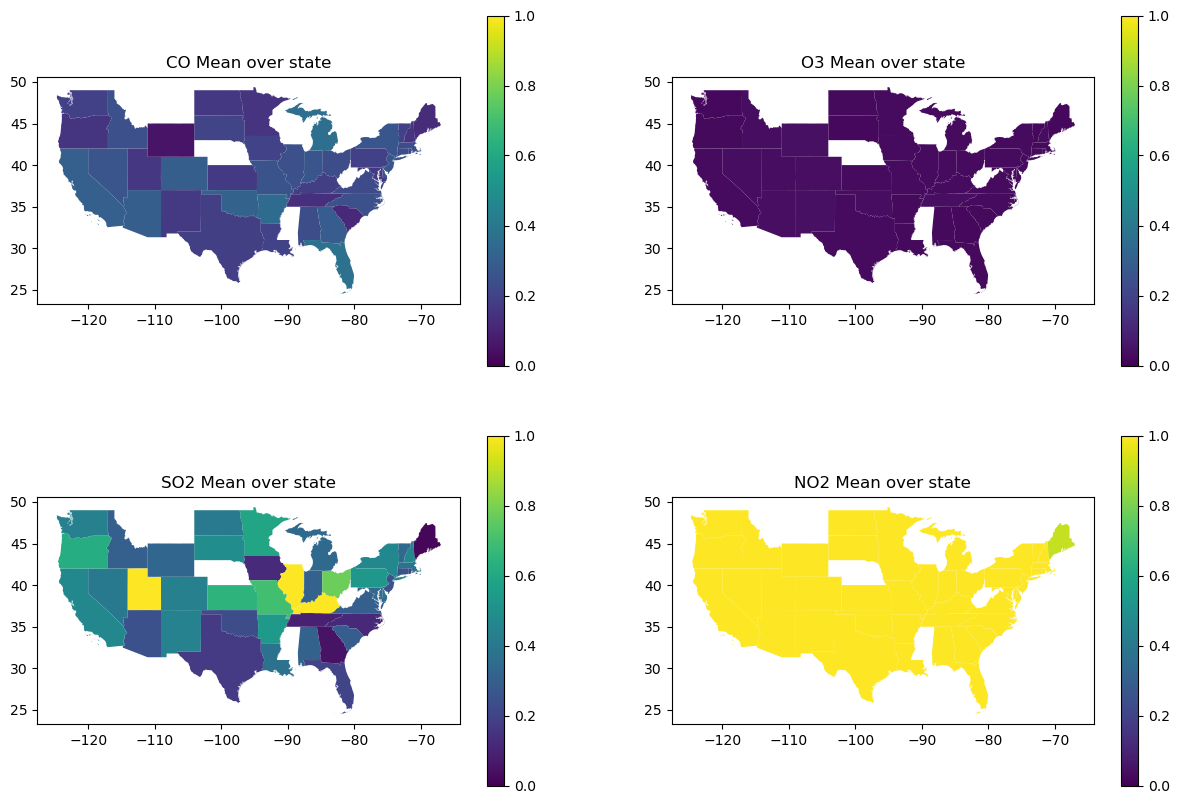

In [32]:
q3_merged_data_subset = gpd.GeoDataFrame(data = merged_data[["State", "CO Mean", "O3 Mean", "SO2 Mean", "NO2 Mean", "geometry"]], 
                                      geometry = "geometry")
q3_merged_data_dissolved = q3_merged_data_subset.dissolve(by = "State", aggfunc = "mean")
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes = axes.ravel()
pollutants = ["CO Mean", "O3 Mean", "SO2 Mean", "NO2 Mean"]
for i in range(0,4):
    q3_merged_data_dissolved.plot(ax=axes[i], column=pollutants[i], legend=True, vmin = 0, vmax = 1)
    axes[i].set(title = f"{pollutants[i]} over state")
plt.show()

Out of all 4 maps, the only pollutant that seems to match the congestion severity map (from question 2) across each state is NO2. When searching "what is the number one pollutant from cars", the result I got was CO2 (which isn't even in this dataset), CO and NO2. I believe the mismatch from CO2 might just be because of real world noise. Because of the amount of noise in this dataset I will also test the correlation between congestion severity and each pollutant using a regplot. My hypothesis is that there isn't a huge correlation.

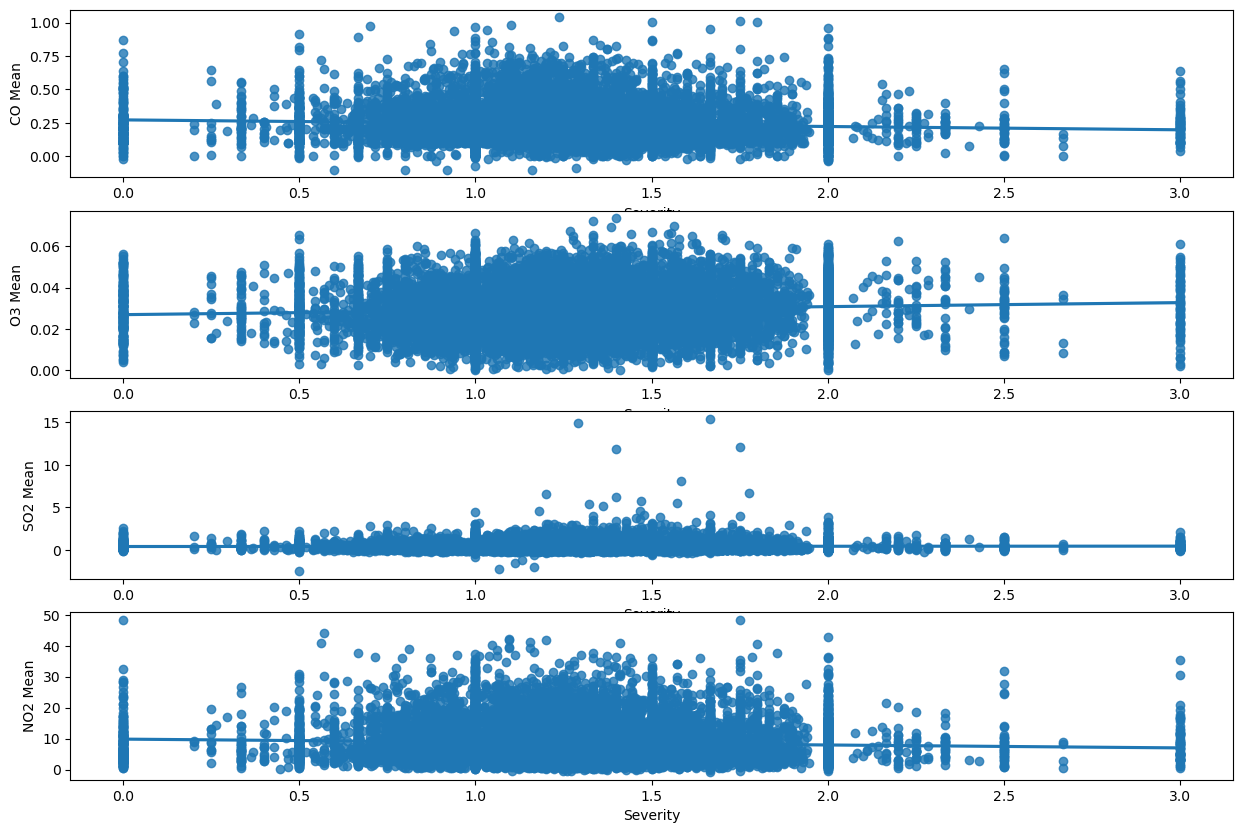

In [34]:
fig, [ax1,ax2,ax3,ax4] = plt.subplots(4, 1, figsize=(15,10))
sns.regplot(merged_data, x="Severity", y="CO Mean", ax = ax1)
sns.regplot(merged_data, x="Severity", y="O3 Mean", ax = ax2)
sns.regplot(merged_data, x="Severity", y="SO2 Mean", ax = ax3)
sns.regplot(merged_data, x="Severity", y="NO2 Mean", ax = ax4)
fig.show()

Here we can see that my hypothesisis somewhat correct, and there isn't a strong correlation between congestion and pollution. The only pollutant which actually hugs the line is SO2, which seemed to be the second closest to congestion severity when comparing maps. My interpretation from this is that congestion may not be the strongest contributor of pollution levels, at least compared to other sources, like fossil fuels.  

## Comparing DecisionTreeRegressor, GradientBoostingRegressor, and RandomForestRegressor for each pollutant in Q3:
For the third question, we are going to train a decision tree to predict the pollution level across each state, congestion level, and accidents. Our predictors will be state, congestion level, and accidents. State is categorical so we will once again need to change it to numerical values using one hot encoding. We want to predict the train and test rsme for each pollutant so we will use a for loop for this.

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

q3_df = pd.get_dummies(merged_data, columns = ["State"], drop_first = True)

q3_state_features = [column for column in q3_df if column.startswith("State_")]

q3_prediction_features = q3_state_features + ["Severity", 
                                          "DelayFromTypicalTraffic(mins)", 
                                          "DelayFromFreeFlowSpeed(mins)", "accidents"]

q3_X = q3_df[q3_prediction_features]

pollutants = ["CO Mean", "O3 Mean", "SO2 Mean", "NO2 Mean"]
result_error = []

#Different models with parameters. Using a dictionary so I can not only access estimators and parameters, but they are
#linked to a name to make the final table more clear.
models = {
            "DecisionTree":(DecisionTreeRegressor(), {"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10]}),
            "RandomForest":(RandomForestRegressor(), {'n_estimators': [100, 200],'max_depth': [None, 10]}),
            "GradientBoosting":(GradientBoostingRegressor(), {'n_estimators': [100],
                                                                       'learning_rate': [0.05, 0.1],
                                                                       'max_depth': [3, 5],}),
        } 

for pollutant in pollutants:
    row = {}
    row["Pollutant"] = pollutant
    q3_y = q3_df[pollutant]
    q3_X_train, q3_X_test, q3_y_train, q3_y_test = train_test_split(q3_X, q3_y, test_size=0.2)
    for model in models:
        estimator = models[model][0]
        param_grid = models[model][1]
        search = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            scoring="neg_root_mean_squared_error",
            verbose=0,
        )
    
        pollutant_predictor = search.fit(q3_X_train, q3_y_train)
        pollutant_reg = pollutant_predictor.best_estimator_
    
        train_rmse = root_mean_squared_error(q3_y_train, pollutant_reg.predict(q3_X_train))
        test_rmse = root_mean_squared_error(q3_y_test, pollutant_reg.predict(q3_X_test))
        row[f"{model}_train_rmse"] = train_rmse
        row[f"{model}_test_rmse"] = test_rmse
        
    result_error.append(row)

result_df = pd.DataFrame(result_error)
result_df.set_index("Pollutant")
result_df

,Pollutant,DecisionTree_train_rmse,DecisionTree_test_rmse,RandomForest_train_rmse,RandomForest_test_rmse,GradientBoosting_train_rmse,GradientBoosting_test_rmse
0,CO Mean,0.108706,0.112452,0.098643,0.106848,0.095722,0.102954
1,O3 Mean,0.009953,0.010195,0.009446,0.010059,0.009279,0.010013
2,SO2 Mean,0.441729,0.398246,0.167698,0.384824,0.389112,0.365326
3,NO2 Mean,5.007766,5.399347,1.906536,5.074363,4.462535,4.912091


Here we can instantly see that best performing model is the GradientBooster, as it has the lowest test error on every single pollutant. However, just to get an idea of whether the GradientBooster is actually good or not we can look at the description of the actual pollutant data.

In [36]:
merged_data[['CO Mean','O3 Mean','SO2 Mean','NO2 Mean']].describe()

,CO Mean,O3 Mean,SO2 Mean,NO2 Mean
count,17857.000000,17857.000000,17857.000000,17857.000000
mean,0.239575,0.029433,0.419997,8.596611
std,0.120404,0.010571,0.490637,5.762412
min,-0.100000,0.000000,-2.508333,-0.843478
25%,0.164674,0.021799,0.133333,4.520833
50%,0.212500,0.029235,0.306945,7.133333
75%,0.291667,0.036559,0.557738,11.200000
max,1.039583,0.073529,15.392067,48.345808


For CO Mean RMSE(0.102954) < std(0.120404). For O3 Mean RMSE(0.010013) < std(0.010571). For SO2 Mean RMSE(0.365326) < std(0.490637). For NO2 Mean RMSE(4.912091) < std(5.762412). For every single pollutant, the RMSE of the GradientBooster is less than the standard deviation.

# Summary for Q3:
For this question I actually think that I would trust the GradientBooster over my own interpretations of the visualizations. Based on the visualizations the only correlations I can identify are between congestion and NO2, and congestion and SO2. My visualizations also show that congestion is extremely high across every single state.

# Impact and Limitations:
1. Who might benefit from your analysis, who might be excluded, and who might be harmed by it?
**Benefited:**
I think many groups can benefit from my analysis given that most of my models have actually learned off the data, and my visualizations are interpretable. 
* For starters, I think commuters would benefit a lot. People who frequently travel and commute would want to know the risk of getting into a car accident. They would also want to get a good idea of how severe congestion could be given the time of year and state they are in.
* Environmentalists would also benefit. Using my analysis they can get an idea of the places and traffic conditions under which pollution is the highest, so they can target these areas approproately.
* Public officials could also benefit as they could understand when and where pollution, traffic congestion, and accidents are the highest.
**Left Out:**
For the sake of data storage I chose to use State instead of a more specific location metric like latitude/longitude or County. If changes were carried out based on my analysis, the problems of rural cities could be left out.
**Harmed:**
As established there is noise in my data and there could be causal factors ommitted. We cannot assume causation from correlation. If my analysis were to be treated that way, many places could be negatively influenced. People could refrain from visiting certain cities due to fear of pollution or congestion. Government and policy changes could divert funding from cities that already have poor infrastructure.

2. How did the data setting impact your results?
The data setting was very beneficial to my results and also had certain drawbacks. All 3 of my datasets had county and lat/long level location data and specific dates. They also contained multiple columns on weather condition, such as wind speed and precipitation. There was a vast range of questions, visualizations, and models I could explore. The main drawback in my data setting was actually the size of the data. Even after my merge was complete, I had 17857 rows and 13 columns left. Prior to merging I had to choose how to shrink my data, so I chose to do it by date and state. After doing this I was exposed to certain limitations in my data.

3. Explain at least 3 limitations of your analysis and how others should use your conclusions
* One big limitation in my data analysis was choosing to use a location metric as broad as state rather than lat/long and county. While this was necessary, for question 2 and 3 where I had to look at congestion data across state, the data did not vary at all.
* Another limitation was my use of weather buckets. In the beginning there were far too many weather categories which would have taken massive computation time and resources to use in my analysis. However, having them may have revealed a significant relationship that could benefit my analysis.
* One final limitation is that while my logistic regressions accuracy is technically 60% compared to a blind guess of 50%, it is still relatively low, thus its predictions cannot be completely trusted.
Ultimately, my analysis should be taken as an inisght into the existing relationships between accidents, pollution, and traffic congestion. It should not be taken as complete truth, and any correlations revealed cannot be 100% labeled as causal relationships.

# Challenge Goals:
All 3 of my challenge goals were completed as per the estimations. I merged 3 different datasets which I used for my data analysis. I also not only trained 3 sci-kit different models for each pollutant, comparing them at the end using a table, but also trained a regression model for my first question and a classification model for my second question, result in 14 different models trained.

# Plan Evaluation:
I think my plan progressed well. I finished my data merging and manipulation, and most of my visualizations in the project EDA phase. For the previous phase I plotted weather and congestion severity against number of accidents. For this phase I just needed to duplicate it except swap out congestion severity with the other metrics such as DelayFromTypicalTraffic(mins) and DelayFromFreeFlowSpeed(mins). I also needed to plot the congestion level against the month and state (which was my second question). Finally I finished my project by training the appropriate model for each question. I estimated this would take 24 hours, and I was able to finish it in the allocated time.

# Testing:
I used doctests for the manipulation functions I created for my dataset (the ones I used with apply). I believe my results should be trusted because due to my data cleaning there are little to no edge cases for my methods. For the weather bucket method, if the method works for every single bucket then the only possible error could be typos, which you can easily confirm do not exist. The same can be said for cut and full_to_abbreviated. Finally, the only method with an edge case is mode_func, where we need to check for multiple modes, and that has been accounted for.